In [2]:
import urllib.parse as urlparse
import pandas as pd
from openpyxl import load_workbook

file_path = '../data/test_data/sideshow test.xlsx'
workbook = load_workbook(file_path, data_only=True)
sheet = workbook.active  # assume in first working sheet

# extract 'Category', 'Headline' and 'Date' column
data = []
for row in sheet.iter_rows(min_row=2, values_only=False):  # start from second row
    category = row[3].value  # category in 4th col
    date = row[0].value      # date in 1st col
    headline_cell = row[4]   # Headline in 5th col
    
    # get url
    url = headline_cell.hyperlink.target if headline_cell.hyperlink else None
    
    # extract real URL
    if url and "google.com/url" in url:
        parsed_url = urlparse.urlparse(url)
        query_params = urlparse.parse_qs(parsed_url.query)
        real_url = query_params.get("url", [None])[0]  # extract real URL
    else:
        real_url = url  # keep redirect hyperlink
    
    data.append([category, date, real_url])

# To DataFrame
df = pd.DataFrame(data, columns=['Category', 'Date', 'URL'])

# filter rows withour URL
df = df.dropna(subset=['URL'])
print(df.head())


     Category       Date                                                URL
0       Music 2016-09-22  http://www.usmagazine.com/entertainment/news/t...
1    Politics 2016-09-24  http://www.heraldscotland.com/opinion/14759994...
2  Mass Media 2016-09-24  http://www.notebookreview.com/feature/nbr-flas...
3    Sideshow 2016-09-25  http://www.mpnnow.com/news/20160923/smith-oper...
4    Sideshow 2016-09-25         https://www.loc.gov/item/fsa1997018934/PP/


In [3]:
import requests
from bs4 import BeautifulSoup
import time

# define function to grab data
def fetch_content(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # extract content
        paragraphs = soup.find_all('p')
        content = " ".join([p.get_text() for p in paragraphs if p.get_text()])
        return content
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

df['Content'] = df['URL'].apply(fetch_content)
time.sleep(1)

df.head()


Error fetching http://www.mpnnow.com/news/20160923/smith-opera-house-to-host-house-of-burlesque-evening-of-classic-burlesque: 404 Client Error: OK for url: https://www.mpnnow.com/news/20160923/smith-opera-house-to-host-house-of-burlesque-evening-of-classic-burlesque
Error fetching http://www.theflindersnews.com.au/story/4187640/quorn-show-success-photos/?cs=1521: 404 Client Error: Not Found for url: https://starnewsgroup.com.au/story/4187640/quorn-show-success-photos/?cs=1521
Error fetching http://www.autoblog.com/2016/09/27/sideshow-spectators-attack-fresno-police-cruiser/: 403 Client Error: Forbidden for url: http://www.autoblog.com/2016/09/27/sideshow-spectators-attack-fresno-police-cruiser/
Error fetching https://www.tradingfloor.com/posts/boj-price-fixing-to-affect-markets-more-than-trump-clinton-sideshow-8089824: HTTPSConnectionPool(host='www.tradingfloor.com', port=443): Max retries exceeded with url: /posts/boj-price-fixing-to-affect-markets-more-than-trump-clinton-sideshow-808

,Category,Date,URL,Content
0,Music,2016-09-22,http://www.usmagazine.com/entertainment/news/t...,"By clicking Sign In, you agree to our Terms an..."
1,Politics,2016-09-24,http://www.heraldscotland.com/opinion/14759994...,\n IF you are watching the Corbyn-Smith show ...
2,Mass Media,2016-09-24,http://www.notebookreview.com/feature/nbr-flas...,Connect with more active buying teams and shap...
3,Sideshow,2016-09-25,http://www.mpnnow.com/news/20160923/smith-oper...,None
4,Sideshow,2016-09-25,https://www.loc.gov/item/fsa1997018934/PP/,Top of page \n\n\n Back to Search Results\n...


In [5]:
df = df.dropna(subset=['Content', 'Category'])

In [6]:
df

,Category,Date,URL,Content
0,Music,2016-09-22,http://www.usmagazine.com/entertainment/news/t...,"By clicking Sign In, you agree to our Terms an..."
1,Politics,2016-09-24,http://www.heraldscotland.com/opinion/14759994...,\n IF you are watching the Corbyn-Smith show ...
2,Mass Media,2016-09-24,http://www.notebookreview.com/feature/nbr-flas...,Connect with more active buying teams and shap...
4,Sideshow,2016-09-25,https://www.loc.gov/item/fsa1997018934/PP/,Top of page \n\n\n Back to Search Results\n...
5,Music,2016-09-26,http://musicfeeds.com.au/news/parquet-courts-a...,\n\tBy\n\t\t\t\n\t\t\tMike Hohnen\t\t\n UPDATE...
...,...,...,...,...
1407,Sports,2016-12-13,http://sports.yahoo.com/news/fantasy-freak-sho...,"On this tearful edition of the program, Brad E..."
1409,Mass Media,2016-12-15,http://www.dreadcentral.com/news/203297/event-...,This past summer I had the pleasure of reporti...
1410,Sports,2016-12-15,http://sports.yahoo.com/news/freak-show-podcas...,"It’s the fantasy semifinals, amigos. Who are y..."
1411,Sports,2016-12-16,http://sports.yahoo.com/news/fantasy-freak-sho...,"On this high voltage program, Brad Evans and B..."


## EDA

In [7]:
df['Category'].value_counts()

Sideshow          210
Politics          191
Sports            139
Music             109
Mass Media         84
Car Show           55
Theatre            27
Art                19
Freakshow          13
Car show           12
Economy            11
Crime               7
sports              6
Tech                3
Wine                3
Mass Meda           3
Celebrity           2
politics            2
Theater             2
Sideshow*           2
Graphic design      1
Graphic Design      1
Antiques            1
Car                 1
Halloween           1
car Show            1
Drunkeness          1
sideshow            1
Name: Category, dtype: int64

In [8]:
# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Display the distribution of categories
print("\nCategory distribution:")
print(df['Category'].value_counts())



Missing values per column:
Category     0
Date        55
URL          0
Content      0
dtype: int64

Category distribution:
Sideshow          210
Politics          191
Sports            139
Music             109
Mass Media         84
Car Show           55
Theatre            27
Art                19
Freakshow          13
Car show           12
Economy            11
Crime               7
sports              6
Tech                3
Wine                3
Mass Meda           3
Celebrity           2
politics            2
Theater             2
Sideshow*           2
Graphic design      1
Graphic Design      1
Antiques            1
Car                 1
Halloween           1
car Show            1
Drunkeness          1
sideshow            1
Name: Category, dtype: int64


/var/folders/jg/btc6sbzd06jdfdnzwvcdpcbm0000gn/T/ipykernel_28935/2050471270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content_length'] = df['Content'].apply(lambda x: len(str(x)))


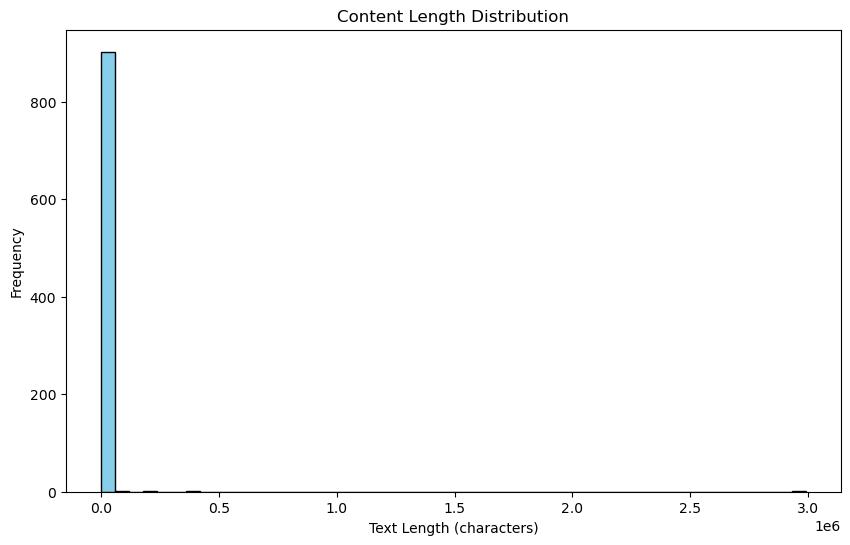

In [9]:
import matplotlib.pyplot as plt

# Calculate the length of each text in the 'content' column
df['content_length'] = df['Content'].apply(lambda x: len(str(x)))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['content_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Content Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Display a few random samples of the 'content' column
sample_texts = df['Content'].sample(5, random_state=42).tolist()
for i, text in enumerate(sample_texts, 1):
    print(f"\nSample {i}:\n{text}\n")



Sample 1:
Black celebrity began at the freak show. When Phillis Wheatley appeared before the great men of Massachusetts in 1772, it was not as the first African-American woman poet but as a vexing human oddity—“an uncultivated Barbarian from Africa” who could write. The supposedly high-minded owners who submitted her to examination were not so different from the showman P. T. Barnum, who in 1835 launched his career with the purchase of an elderly, paralytic slave woman named Joice Heth. Barnum exhibited Heth as George Washington’s 161-year-old “mammy,” using her black body to catapult him from dry goods salesman to global entertainment icon. She was the first in a long chain of “African entertainments”—Zip the Pinhead, the Duck-Billed Ubangis, the pygmy Ota Benga—on whose backs Barnum and his successors rode to glory. They were the sacrificial lambs of modern entertainment, and they have been, as individuals, almost entirely forgotten. George and Willie Muse, sideshow performers for d

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the text cleaning function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords and perform lemmatization
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Rejoin words into a single string
    return ' '.join(words)

# Apply the cleaning function to the 'content' column
df['cleaned_content'] = df['Content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /Users/a123/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/a123/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/jg/btc6sbzd06jdfdnzwvcdpcbm0000gn/T/ipykernel_28935/3786623964.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_content'] = df['Content'].apply(preprocess_text)


In [12]:
# Display a few cleaned samples to verify the cleaning function
sample_cleaned_texts = df['cleaned_content'].sample(5, random_state=42).tolist()
for i, text in enumerate(sample_cleaned_texts, 1):
    print(f"\nCleaned Sample {i}:\n{text}\n")



Cleaned Sample 1:
black celebrity began freak show phillis wheatley appeared great men massachusetts first africanamerican woman poet vexing human oddityan uncultivated barbarian africa could write supposedly highminded owner submitted examination different showman p barnum launched career purchase elderly paralytic slave woman named joice heth barnum exhibited heth george washington yearold mammy using black body catapult dry good salesman global entertainment icon first long chain african entertainmentszip pinhead duckbilled ubangis pygmy ota bengaon whose back barnum successor rode glory sacrificial lamb modern entertainment individual almost entirely forgotten george willie muse sideshow performer dime museum circus including ringling bros barnum bailey known life eko iko often trailing sobriquet like darwin missing link ambassador mar done tuxedo wearing blond hair tangled dread traveled across america ogled silent music played accompaniment hype men told journalist rube sideshow

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder and fit-transform the 'Category' column
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Category'])

# Display the label encoding mapping
print("\nLabel Mapping:")
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))



Label Mapping:
{'Antiques': 0, 'Art': 1, 'Car': 2, 'Car Show': 3, 'Car show': 4, 'Celebrity': 5, 'Crime': 6, 'Drunkeness': 7, 'Economy': 8, 'Freakshow': 9, 'Graphic Design': 10, 'Graphic design': 11, 'Halloween': 12, 'Mass Meda': 13, 'Mass Media': 14, 'Music': 15, 'Politics': 16, 'Sideshow': 17, 'Sideshow*': 18, 'Sports': 19, 'Tech': 20, 'Theater': 21, 'Theatre': 22, 'Wine': 23, 'car Show': 24, 'politics': 25, 'sideshow': 26, 'sports': 27}


/var/folders/jg/btc6sbzd06jdfdnzwvcdpcbm0000gn/T/ipykernel_28935/598446252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = label_encoder.fit_transform(df['Category'])


In [15]:
# define dict and map
category_mapping = {
    'Graphic design': 'Graphic Design', 
    'Mass Meda': 'Mass Media'            
}

# use dict to replace label
df['Category'] = df['Category'].replace(category_mapping)

# encode label
df['label_encoded'] = label_encoder.fit_transform(df['Category'])

# read label with mappings
print("\nUpdated Label Mapping:")
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))



Updated Label Mapping:
{'Antiques': 0, 'Art': 1, 'Car': 2, 'Car Show': 3, 'Car show': 4, 'Celebrity': 5, 'Crime': 6, 'Drunkeness': 7, 'Economy': 8, 'Freakshow': 9, 'Graphic Design': 10, 'Halloween': 11, 'Mass Media': 12, 'Music': 13, 'Politics': 14, 'Sideshow': 15, 'Sideshow*': 16, 'Sports': 17, 'Tech': 18, 'Theater': 19, 'Theatre': 20, 'Wine': 21, 'car Show': 22, 'politics': 23, 'sideshow': 24, 'sports': 25}


/var/folders/jg/btc6sbzd06jdfdnzwvcdpcbm0000gn/T/ipykernel_28935/2596573188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'] = df['Category'].replace(category_mapping)
/var/folders/jg/btc6sbzd06jdfdnzwvcdpcbm0000gn/T/ipykernel_28935/2596573188.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = label_encoder.fit_transform(df['Category'])


In [18]:
df.to_csv("cleaned_freakshow_training.csv", index=False)